# Part 1: Proof of Concept Program
This program involves the implementation of Ridge Regression and Kernel Ridge Regression on a sample dataset. The models created from the custom algorithms are then evaluated and their performance is compared to sklearn's inbuilt functions for ridge regression

In [1]:
import numpy as np
import pandas as pd
from typing import List
from numpy.linalg import inv
from scipy import linalg
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge

In [2]:
class RidgeRegression:
    def __init__(self, learning_rate: float, reg_strength: float, max_iter: int):
        """Initialize.
        Args:
            learning_rate (float): Learning rate for gradient descent.
            reg_strength (float): Regularization parameter, to control the bias-variance tradeoff.
            max_iter (int): Number of iterations to run gradient descent.
        """
        self.learn_rate = learning_rate
        self.reg_strength = reg_strength
        self.max_iter = max_iter
        self._weights: np.array
        self.X_train: np.array
        self.y_train: np.array
        self.train_size: int
        self.features: int

    def weights(self):
        """Return ridge regression model weights."""
        return self._weights

    def fit(self, x_train, y_train):
        """Fit model weights to training data."""
        self.train_size, self.features = x_train.shape[0], x_train.shape[1]
        self.X_train = np.append(np.ones(self.train_size).reshape(-1, 1), x_train, axis=1)  # Add one for the intercept term for all training examples.
        self.y_train = y_train.to_numpy()
        self._weights = np.zeros(self.features + 1)  # +1 for the intercept.

        self.optimize_weights()

    def optimize_weights(self):
        """Optimize model weights for self.max_iter iterations."""
        for _ in range(self.max_iter):
            self.update_step()    

    def update_step(self):
        """Update model weights with batch gradient descent step.
       The update statement for a model weight theta_k is:
        theta_k = theta_k - (learn_rate * J_theta_k)
        where J_theta_k = cost function
              J_theta_k = (2 / train_size) * ( ((y_hat - y_real) * x_k) + (alpha * theta_k^2))
        """
        y_hat = (self._weights * self.X_train).sum(axis=1)
        errors = (y_hat - self.y_train).reshape(-1, 1)

        j_theta = (2 / self.train_size) * ((errors * self.X_train).sum(axis=0) +
                                           (self.reg_strength * self._weights))
        step = self.learn_rate * j_theta

        self._weights = self._weights - step.reshape(-1)
        
    def predict(self, x_test):

        test_size = x_test.shape[0]
        x_test = np.append(np.ones(test_size).reshape(-1, 1), x_test, axis=1)

        return (self._weights * x_test).sum(axis=1)


In [3]:
class KernelRidge:
    """
        kernel_type: Kernel type to use in training.
                        'linear' use linear kernel function.
                        'quadratic' use quadratic kernel function.
                        'gaussian' use gaussian kernel function
        C: Value of regularization parameter C
        gamma: parameter for gaussian kernel or Polynomial kernel
        """
    def __init__(self, kernel_type: str, C:float, gamma:float):
        self.kernels = {
            'linear': self.kernel_linear,
            'quadratic': self.kernel_quadratic,
            'gaussian': self.kernel_gaussian
        }
        self.kernel_type = kernel_type
        self.kernel = self.kernels[self.kernel_type]
        self.C = C
        self.gamma = gamma

    # Define kernels
    def kernel_linear(self, x1, x2):
        return np.dot(x1, x2.T)

    def kernel_quadratic(self, x1, x2):
        return (np.dot(x1, x2.T) ** 2)

    def kernel_gaussian(self, x1, x2, gamma=5.0):
        gamma = self.gamma
        return np.exp(-linalg.norm(x1 - x2) ** 2 / (2 * (gamma ** 2)))

    def compute_kernel_matrix(self, X1, X2):
        """
        compute kernel matrix (gram matrix) give two input matrix
        """

        # sample size
        n1 = X1.shape[0]
        n2 = X2.shape[0]

        # Gram matrix
        K = np.zeros((n1, n2))
        for i in range(n1):
            for j in range(n2):
                K[i, j] = self.kernel(X1[i], X2[j])

        return K


    def fit(self, X, y):

        X = np.append(np.ones(X.shape[0]).reshape(-1, 1), X, axis=1)  # Add one for the intercept term for all training examples.
        
        K = self.compute_kernel_matrix(X,X)

        self.alphas = np.dot(inv(K + self.C * np.eye(np.shape(K)[0])),
                        y.transpose())    
        return self.alphas

    def predict(self, x_train, x_test):

        k = self.compute_kernel_matrix(x_test, x_train)

        y_test = np.dot(k, self.alphas)
        return y_test.transpose()
    
    def predict(self, x_train, x_test):

        k = self.compute_kernel_matrix(x_test, x_train)

        y_test = np.dot(k, self.alphas)
        return y_test.transpose()

## Data Preparation
### Data split function

In [4]:
# Fuction to split the data into train and test sets

def split_train_test(x_data: np.array, y_labels: np.array, features: list,
                         test_size: float) -> dict:
    
    x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                        y_labels,
                                                        test_size=test_size,
                                                        random_state=41,
                                                        shuffle=True)
    return_val = {
        'x_train': pd.DataFrame(x_train, columns=features),
        'x_test': pd.DataFrame(x_test, columns=features),
        'y_train': pd.Series(y_train),
        'y_test': pd.Series(y_test)
    }
    return return_val
 

### Loading the data

In [5]:
data = pd.read_csv('References\salary_data.csv')

# Shuffling the dataset
data = shuffle(data)

feature_list = list(data.columns)
target = 'Salary'
feature_list.remove(target)

# Create the train and test splits
data_splits = split_train_test(x_data=data[feature_list].to_numpy(),
                                                 y_labels=data[target].to_numpy(),
                                                 features=feature_list,
                                                 test_size=0.2)


## Data normalization

In [6]:
# sklearn StandardScaler() function to normalize the data
scaler = StandardScaler()

#Standardize features
dframe=data_splits['x_train']
features=feature_list
scaler.fit(X=dframe[features])

# Store the train set mean and variance to be used to normalize the test set.
train_means = scaler.mean_
train_vars = scaler.var_

data_splits['x_train'] = scaler.transform(X=dframe[features])

#Standardize the test_set using the training set feature means and variances
dframe=data_splits['x_test']

centered_df = dframe[features] - train_means
data_splits['x_test'] = centered_df / (train_vars**0.5)

## Model Comparison

In [7]:
def get_ridge_regression_score(data_splits: dict, reg_strength: float, max_iter: int):
    ridge_obj = RidgeRegression(learning_rate=0.01, reg_strength=reg_strength, max_iter=max_iter)
    ridge_obj.fit(data_splits['x_train'], data_splits['y_train'])
    predictions = ridge_obj.predict(data_splits['x_test'])
    return mean_absolute_percentage_error(y_true=data_splits['y_test'], y_pred=predictions)

def get_kernel_ridge_regression_score(data_splits: dict,kernel_type:str, C:float, gamma:float):
    kridge_obj = KernelRidge(kernel_type = kernel_type, C=C ,gamma = gamma)
    kridge_obj.fit(data_splits['x_train'], data_splits['y_train'])
    predictions = kridge_obj.predict(data_splits['x_train'],data_splits['x_test'].values)
    return mean_absolute_percentage_error(y_true=data_splits['y_test'], y_pred=predictions)

def get_sklearn_prediction_score(data_splits: dict, reg_strength: float, max_iter: int):
    clf = Ridge(alpha=reg_strength, solver='sag', max_iter=max_iter)
    model = clf.fit(data_splits['x_train'], data_splits['y_train'])
    predictions = model.predict(data_splits['x_test'])
    return mean_absolute_percentage_error(y_true=data_splits['y_test'], y_pred=predictions)


In [8]:
# Performance metic fuction

def mean_absolute_percentage_error(y_true, y_pred):
    """Return mean absolute percentage error of y_pred."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    abs_errors = np.abs((y_true - y_pred) / y_true)
    return np.mean(abs_errors) * 100


In [9]:
def predict():
    ridge_reg_score = get_ridge_regression_score(data_splits, reg_strength=10, max_iter=1000)
    kernel_ridge_score = get_kernel_ridge_regression_score(data_splits,kernel_type='gaussian', C=1.0, gamma=5.0)
    sklearn_score = get_sklearn_prediction_score(data_splits, reg_strength=10, max_iter=1000)
    return ridge_reg_score, kernel_ridge_score, sklearn_score 

In [10]:
ridge_reg_score, kernel_ridge_score, sklearn_score = predict()
print(ridge_reg_score)
print(kernel_ridge_score)
print(sklearn_score)

29.58985412927025
22.534719131764415
13.883414901915089


The Kernel Ridge implementation outperforms the basic ridge regression model. However, when compared to the sklearn model score, this custom implementation has a higher error rate. The error should reduce with hyperparameter tuning, and this is expored in the following sections. 

# Part 2

This section entails the application of our custom model to the Boston House Price Prediction dataset. The data is preprocessed to encode categorical variables and normalized using sklearn's StandardScaler() function. After the data prepaation section, the model is tested with different a pool of parameters in  order to determine the best parameter values for optimal performance. <br>Finally, the best model is selected and compared with other regression algorithms inbuilt within sklearn such as the Support Vector Regressor,Decision Tree Regressor, Random Forest Regressor and the KNN Regressor. Also applied are the XGBoost regressor and the Keras Regressor. Their performance is then compared and vizualized.

## Data Preparation

In [11]:
from sklearn.datasets import load_boston
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Loading the data
boston_dataset = load_boston()
data = pd.DataFrame(boston_dataset.data, columns = boston_dataset.feature_names)
data['MEDV'] = boston_dataset.target
target = 'MEDV'

# Encoding the categotical variables
onehot = OneHotEncoder(sparse = False)
data['CHAS'] = onehot.fit_transform(data['CHAS'].values.reshape(-1, 1))

encoder = OrdinalEncoder()
data['RAD'] = encoder.fit_transform(data['RAD'].values.reshape(-1, 1))

feature_list = list(data.columns)
feature_list.remove(target)

data_splits = split_train_test(x_data=data[feature_list].to_numpy(),
                                                 y_labels=data[target].to_numpy(),
                                                 features=feature_list,
                                                 test_size=0.2)


## Data Normalization

In [12]:
# sklearn StandardScaler() function to normalize the data
scaler = StandardScaler()

#Standardize features
dframe=data_splits['x_train']
features=feature_list
scaler.fit(X=dframe[features])

# Store the train set mean and variance to be used to normalize the test set.
train_means = scaler.mean_
train_vars = scaler.var_

data_splits['x_train'] = scaler.transform(X=dframe[features])

#Standardize the test_set using the training set feature means and variances
dframe=data_splits['x_test']

centered_df = dframe[features] - train_means
data_splits['x_test'] = centered_df / (train_vars**0.5)

In [13]:
ridge_reg_score, kernel_ridge_score, sklearn_score = predict()
print(ridge_reg_score)
print(kernel_ridge_score)
print(sklearn_score)

18.673518762809906
14.589194639978064
18.81712497120318


## Feature selection for the Kernel Ridge Model

In [14]:
C_range = [0.0025,0.01,1,5,10,50]
gamma_range = [0.1,1,2,5,10,50]
kernel_range  = ['linear','quadratic','gaussian']

MAPE_vary_C = []
MAPE_vary_gamma = []
MAPE_vary_kernel = []

for C in C_range:
    model = KernelRidge(kernel_type = 'gaussian', C=C ,gamma = 5)
    model.fit(data_splits['x_train'], data_splits['y_train'])
    predictions = model.predict(data_splits['x_train'],data_splits['x_test'].values)
    error = mean_absolute_percentage_error(y_true=data_splits['y_test'], y_pred=predictions)  
    MAPE_vary_C.append(error)
    
for gamma in gamma_range:
    model = KernelRidge(kernel_type = 'gaussian', C=0.01 ,gamma = gamma)
    model.fit(data_splits['x_train'], data_splits['y_train'])
    predictions = model.predict(data_splits['x_train'],data_splits['x_test'].values)
    error = mean_absolute_percentage_error(y_true=data_splits['y_test'], y_pred=predictions)  
    MAPE_vary_gamma.append(error)
    
for kernel in kernel_range:
    model = KernelRidge(kernel_type = kernel, C=0.01 ,gamma = 5)
    model.fit(data_splits['x_train'], data_splits['y_train'])
    predictions = model.predict(data_splits['x_train'],data_splits['x_test'].values)
    error = mean_absolute_percentage_error(y_true=data_splits['y_test'], y_pred=predictions)  
    MAPE_vary_kernel.append(error)

Text(0, 0.5, 'MAPE')

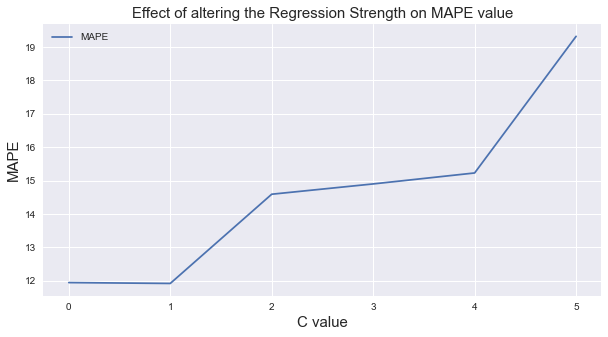

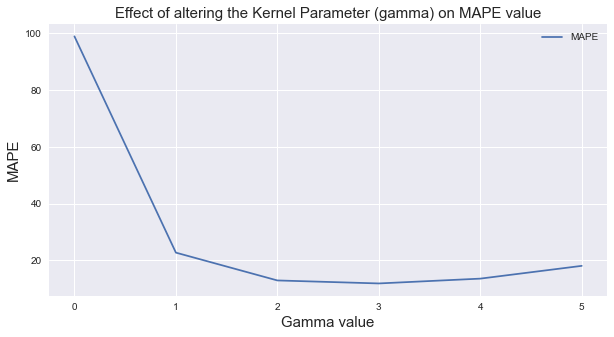

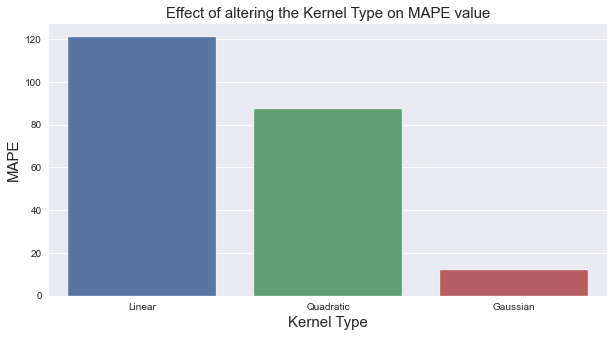

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale = 2)
plt.style.use('seaborn')
%matplotlib inline

# Plots
vary_C_df = pd.DataFrame(MAPE_vary_C, columns=['MAPE'])
plt.figure(figsize=(10,5))
sns.lineplot(data=vary_C_df)
plt.title('Effect of altering the Regression Strength on MAPE value', fontsize = 15)
plt.xlabel('C value',fontsize = 15)
plt.ylabel('MAPE',fontsize = 15)

vary_gamma_df = pd.DataFrame(MAPE_vary_gamma, columns=['MAPE'])
plt.figure(figsize=(10,5))
sns.lineplot(data=vary_gamma_df)
plt.title('Effect of altering the Kernel Parameter (gamma) on MAPE value', fontsize = 15)
plt.xlabel('Gamma value', fontsize = 15)
plt.ylabel('MAPE', fontsize = 15)

vary_kernel_df = pd.DataFrame(MAPE_vary_kernel, columns=['MAPE'])
vary_kernel_df['Kernel'] = ['Linear','Quadratic', 'Gaussian']
plt.figure(figsize=(10,5))
sns.barplot(x='Kernel',y='MAPE',data=vary_kernel_df)
plt.title('Effect of altering the Kernel Type on MAPE value', fontsize = 15)
plt.xlabel('Kernel Type', fontsize = 15)
plt.ylabel('MAPE', fontsize = 15)


In [16]:
feature_df = pd.DataFrame()
feature_df['C Values'] = C_range
feature_df['C MAPE'] = MAPE_vary_C
feature_df['Gamma Values'] = gamma_range
feature_df['Gamma MAPE'] = MAPE_vary_gamma
feature_df

,C Values,C MAPE,Gamma Values,Gamma MAPE
0,0.0025,11.940888,0.1,98.866805
1,0.0100,11.914974,1.0,22.757247
2,1.0000,14.589195,2.0,12.973612
3,5.0000,14.897592,5.0,11.914974
4,10.0000,15.226189,10.0,13.609057
5,50.0000,19.320487,50.0,18.103361


From the above plots, it is evident that the <b>gaussian kernel</b> performs better that its counterparts, and it is thus selected. It can also be seen that the error inceases with increase in the regularization parameter. From the table above, the C value with the lowest error is<b> 0.01</b> while the gamma value with the lowest error is <b>5.0</b>. Therefore, these values are selected for the final model.

In [17]:
# Evaluate the model with optimal parameters
optimal_kernel_ridge = get_kernel_ridge_regression_score(data_splits,kernel_type='gaussian', C=0.01, gamma=5.0)
optimal_kernel_ridge

11.914974463848505

# Comparison with other algorithms

## Kernel Ridge Regression

In [18]:
from sklearn.metrics import r2_score

regressor_krr = KernelRidge(kernel_type = 'gaussian', C=0.01 ,gamma = 5.0)
regressor_krr.fit(data_splits['x_train'], data_splits['y_train']);

In [19]:
data_splits['x_train'],data_splits['x_test'].values

# Predicting the Model's R2 Score 
y_pred_krr =regressor_krr.predict(data_splits['x_train'],data_splits['x_test'].values)
r2_score_krr = r2_score(data_splits['y_test'], y_pred_krr)

# Predicting MAPE the Test set results
mape_krr = mean_absolute_percentage_error(data_splits['y_test'], y_pred_krr)
print('R2_score: ', r2_score_krr)
print("MAPE: ", mape_krr)

R2_score:  0.7609600328729184
MAPE:  11.914974463848505


## Support Vector Regression

In [20]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

svr_regressor = SVR(kernel='rbf', gamma='auto')
svr_regressor.fit(data_splits['x_train'], data_splits['y_train'])

SVR(gamma='auto')

In [21]:
# Predicting the Model's R2 Score 
y_pred_svr =svr_regressor.predict(data_splits['x_test'])
r2_score_svr = r2_score(data_splits['y_test'],y_pred_svr)

# Predicting MAPE the Test set results
mape_svr = mean_absolute_percentage_error(data_splits['y_test'], y_pred_svr)
print('R2_score: ', r2_score_svr)
print("MAPE: ", mape_svr)

R2_score:  0.6970284552507131
MAPE:  16.350502513464697


## Decision Tree Regression

In [22]:
# Fitting the Decision Tree Regression Model to the dataset
from sklearn.tree import DecisionTreeRegressor
regressor_dt = DecisionTreeRegressor(random_state = 0)
regressor_dt.fit(data_splits['x_train'], data_splits['y_train'])

DecisionTreeRegressor(random_state=0)

In [23]:
# Predicting the Model's R2 Score 
y_pred_dt =regressor_dt.predict(data_splits['x_test'])
r2_score_dt = r2_score(data_splits['y_test'],y_pred_dt)

# Predicting MAPE the Test set results
mape_dt = mean_absolute_percentage_error(data_splits['y_test'], y_pred_dt)
print('R2_score: ', r2_score_dt)
print("MAPE: ", mape_dt)

R2_score:  0.3531968587732246
MAPE:  16.514877852008784


## Random Forest Regression

In [24]:
# Fitting the Random Forest Regression to the dataset
from sklearn.ensemble import RandomForestRegressor
regressor_rf = RandomForestRegressor(n_estimators = 500, random_state = 0)
regressor_rf.fit(data_splits['x_train'], data_splits['y_train'])

RandomForestRegressor(n_estimators=500, random_state=0)

In [25]:
# Predicting the Model's R2 Score 
y_pred_rf =regressor_rf.predict(data_splits['x_test'])
r2_score_rf = r2_score(data_splits['y_test'],y_pred_rf)

# Predicting MAPE the Test set results
mape_rf = mean_absolute_percentage_error(data_splits['y_test'], y_pred_rf)
print('R2_score: ', r2_score_rf)
print("MAPE: ", mape_rf)

R2_score:  0.6150818630933684
MAPE:  14.143096306618721


## KNN Regression

In [26]:
# Fitting the K Nearest Neighbours Regression to the dataset
from sklearn import neighbors
regressor_knn =neighbors.KNeighborsRegressor(n_neighbors = 10)
regressor_knn.fit(data_splits['x_train'], data_splits['y_train'])

KNeighborsRegressor(n_neighbors=10)

In [27]:
# Predicting the Model's R2 Score 
y_pred_knn =regressor_knn.predict(data_splits['x_test'])
r2_score_knn = r2_score(data_splits['y_test'],y_pred_knn)

# Predicting MAPE the Test set results
mape_knn = mean_absolute_percentage_error(data_splits['y_test'], y_pred_knn)
print('R2_score: ', r2_score_knn)
print("MAPE: ", mape_knn)

R2_score:  0.6569215073377351
MAPE:  14.369750739585019


## XGBoost Regression

In [28]:
import xgboost
from xgboost import XGBRegressor

# create an xgboost regression model
regressor_xgb = XGBRegressor(
    n_estimators=1000, 
    max_depth=7, 
    eta=0.1, 
    subsample=0.7, 
    colsample_bytree=0.8,
)

regressor_xgb.fit(data_splits['x_train'], data_splits['y_train'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [29]:
# Predicting the Model's R2 Score 
y_pred_xgb =regressor_xgb.predict(data_splits['x_test'].values)
r2_score_xgb = r2_score(data_splits['y_test'],y_pred_xgb)

# Predicting MAPE the Test set results
mape_xgb = mean_absolute_percentage_error(data_splits['y_test'], y_pred_xgb)
print('R2_score: ', r2_score_xgb)
print("MAPE: ", mape_xgb)

R2_score:  0.725278895747855
MAPE:  11.924203209567874


In [30]:
import tensorflow
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor

import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore') # Suppress warnings

# create model
model = Sequential()
model.add(Dense(13, input_dim=13, kernel_initializer='normal', activation='relu'))
model.add(Dense(2670, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])

history =model.fit(data_splits['x_train'], data_splits['y_train'], epochs=30, batch_size=150, verbose=1, validation_split=0.2);

C:\Users\chepk\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\chepk\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\chepk\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\chepk\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 323 samples, validate on 81 samples
Epoch 1/30
323/323 [==============================] - 5s 14ms/sample - loss: 620.1098 - mean_squared_error: 620.1097 - mean_absolute_error: 22.9218 - val_loss: 588.4044 - val_mean_squared_error: 588.4044 - val_mean_absolute_error: 22.3690
Epoch 2/30
323/323 [==============================] - 0s 56us/sample - loss: 609.1083 - mean_squared_error: 609.1083 - mean_absolute_error: 22.6749 - val_loss: 575.7065 - val_mean_squared_error: 575.7065 - val_mean_absolute_error: 22.0745
Epoch 3/30
323/323 [==============================] - 0s 56us/sample - loss: 596.1759 - mean_squared_error: 596.1759 - mean_absolute_error: 22.3790 - val_loss: 559.9462 - val_mean_squared_error: 559.9462 - val_mean_absolute_error: 21.7064
Ep

In [31]:
# Predicting the Model's R2 Score 
y_pred_NN = model.predict(data_splits['x_test'].values)
r2_score_NN = r2_score(data_splits['y_test'],y_pred_NN)

# Predicting MAPE the Test set results
mape_NN = mean_absolute_percentage_error(data_splits['y_test'], y_pred_NN)
print('R2_score: ', r2_score_NN)
print("MAPE: ", mape_NN)

R2_score:  0.43148545666598426
MAPE:  45.34963791874118


In [32]:
models = [('Ridge Regressor', mape_krr, r2_score_krr),
          ('Support Vector Regressor', mape_svr, r2_score_svr),
          ('Decision Tree Regressor', mape_dt, r2_score_dt),
          ('Random Forest Regressor', mape_rf, r2_score_rf),  
          ('KNN Regressor', mape_knn, r2_score_knn),
          ('XGBoost Regressor', mape_xgb, r2_score_xgb),
          ('Keras Regressor', mape_NN, r2_score_NN)
         ]

In [33]:
predict = pd.DataFrame(data = models, columns=['Model', 'MAPE', 'R2_Score'])
predict

,Model,MAPE,R2_Score
0,Ridge Regressor,11.914974,0.760960
1,Support Vector Regressor,16.350503,0.697028
2,Decision Tree Regressor,16.514878,0.353197
3,Random Forest Regressor,14.143096,0.615082
4,KNN Regressor,14.369751,0.656922
5,XGBoost Regressor,11.924203,0.725279
6,Keras Regressor,45.349638,0.431485


## Visualizing Model Performance 

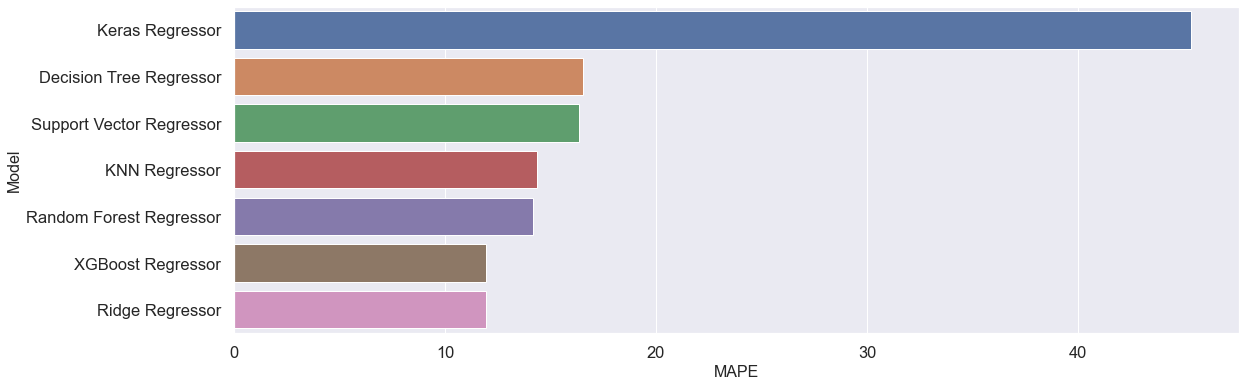

In [34]:
predict.sort_values(by=['MAPE'], ascending=False, inplace=True)

sns.set(font_scale = 1.5)
f, axe = plt.subplots(1,1, figsize=(18,6))
sns.barplot(x='MAPE', y='Model', data=predict, ax = axe)
axe.set_xlabel('MAPE', size=16)
axe.set_ylabel('Model', size=16)

plt.show()


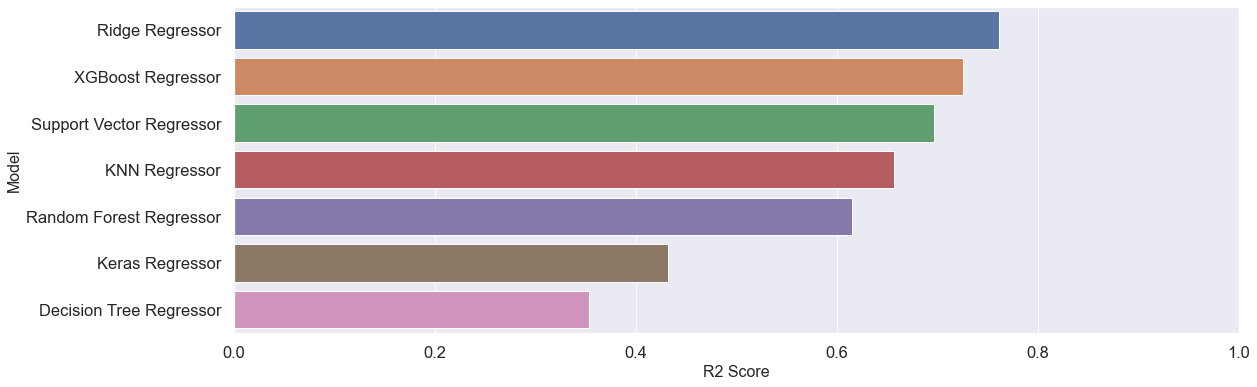

In [35]:
f, axe = plt.subplots(1,1, figsize=(18,6))

predict.sort_values(by=['R2_Score'], ascending=False, inplace=True)

sns.set(font_scale = 1.5)
sns.barplot(x='R2_Score', y='Model', data = predict, ax = axe)
#axes[0].set(xlabel='Region', ylabel='Charges')
axe.set_xlabel('R2 Score', size=16)
axe.set_ylabel('Model', fontsize = 16)
axe.set_xlim(0,1.0)
plt.show()

# Conclusion
The Kernel Ridge Regression perfoms extremely well compared to the other regression algorithm, having the highest R2 score and the lowest error. This is to show that it has overcome the problem of overfitting by its ability to generalize well when exposed to unseen data. On the other hand, the Neural network based model (the Keras regressor) performs very poorly and is clearly not suitable to solve regression problems. 